In [1]:
'''!pip install '''

'!pip install '

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib.ticker import PercentFormatter
from scipy.stats import f_oneway



# 1. Data Acquisition and Initial Exploration

In [3]:
df = pd.read_csv('Airline_Delay_Cause.csv')
pd.set_option('display.max_columns', 100)
print("Shape of the dataset:\n")
display(df.shape)

print("\nFirst few rows of data:")
display(df.head())

print("\nData types:")
print(df.dtypes.value_counts())

print("\nMissing values summary:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Shape of the dataset:



(179338, 21)


First few rows of data:


year  month carrier       carrier_name airport  \
0  2023     12      9E  Endeavor Air Inc.     ABE   
1  2023     12      9E  Endeavor Air Inc.     AEX   
2  2023     12      9E  Endeavor Air Inc.     AGS   
3  2023     12      9E  Endeavor Air Inc.     ALB   
4  2023     12      9E  Endeavor Air Inc.     ATL   

                                        airport_name  arr_flights  arr_del15  \
0  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...         72.0        5.0   
1           Alexandria, LA: Alexandria International         62.0        7.0   
2        Augusta, GA: Augusta Regional at Bush Field         95.0       10.0   
3                   Albany, NY: Albany International         23.0        2.0   
4  Atlanta, GA: Hartsfield-Jackson Atlanta Intern...       2111.0      256.0   

   carrier_ct  weather_ct  nas_ct  security_ct  late_aircraft_ct  \
0        2.46        1.00    0.73          0.0              0.81   
1        4.25        0.00    1.00          0.0              1.75   
2        5.94        0.00    1.06          0.0              3.00   
3        0.56        0.00    0.00          0.0              1.44   
4       76.88        8.75   52.43          0.0            117.94   

   arr_cancelled  arr_diverted  arr_delay  carrier_delay  weather_delay  \
0            0.0           0.0      672.0           61.0          574.0   
1            0.0           0.0      348.0          252.0            0.0   
2            0.0           0.0      859.0          536.0            0.0   
3            1.0           0.0       75.0            9.0            0.0   
4            1.0           0.0    21424.0         8906.0          732.0   

   nas_delay  security_delay  late_aircraft_delay  
0       20.0             0.0                 17.0  
1       33.0             0.0                 63.0  
2       47.0             0.0                276.0  
3        0.0             0.0                 66.0  
4     1487.0             0.0              10299.0


Data types:
float64    15
object      4
int64       2
Name: count, dtype: int64

Missing values summary:
arr_flights            341
arr_del15              591
carrier_ct             341
weather_ct             341
nas_ct                 341
security_ct            341
late_aircraft_ct       341
arr_cancelled          341
arr_diverted           341
arr_delay              341
carrier_delay          341
weather_delay          341
nas_delay              341
security_delay         341
late_aircraft_delay    341
dtype: int64


In [4]:
print("Flight volume stats:")
print(df['arr_flights'].describe())

print("\nDelay counts validation:")
print(f"Total delayed flights: {df['arr_del15'].sum():,}")
print(f"Rows where delays > total flights: {len(df[df['arr_del15'] > df['arr_flights']])}")

Flight volume stats:
count    178997.000000
mean        327.816969
std         931.001446
min           1.000000
25%          41.000000
50%          89.000000
75%         218.000000
max       21977.000000
Name: arr_flights, dtype: float64

Delay counts validation:
Total delayed flights: 10,494,073.0
Rows where delays > total flights: 0


In [5]:
delay_causes = ['carrier', 'weather', 'nas', 'security', 'late_aircraft']
cause_cols = [f'{cause}_ct' for cause in delay_causes]

if all(col in df.columns for col in cause_cols):
    df['total_causes'] = df[cause_cols].sum(axis=1)
    discrepancy = df['arr_del15'] - df['total_causes']
    
    print("\nDelay cause composition:")
    print(f"Mean unaccounted delays: {discrepancy.mean():.1f}")
    print(f"Rows with over-accounting: {len(df[discrepancy < 0])}")


Delay cause composition:
Mean unaccounted delays: -0.0
Rows with over-accounting: 22414


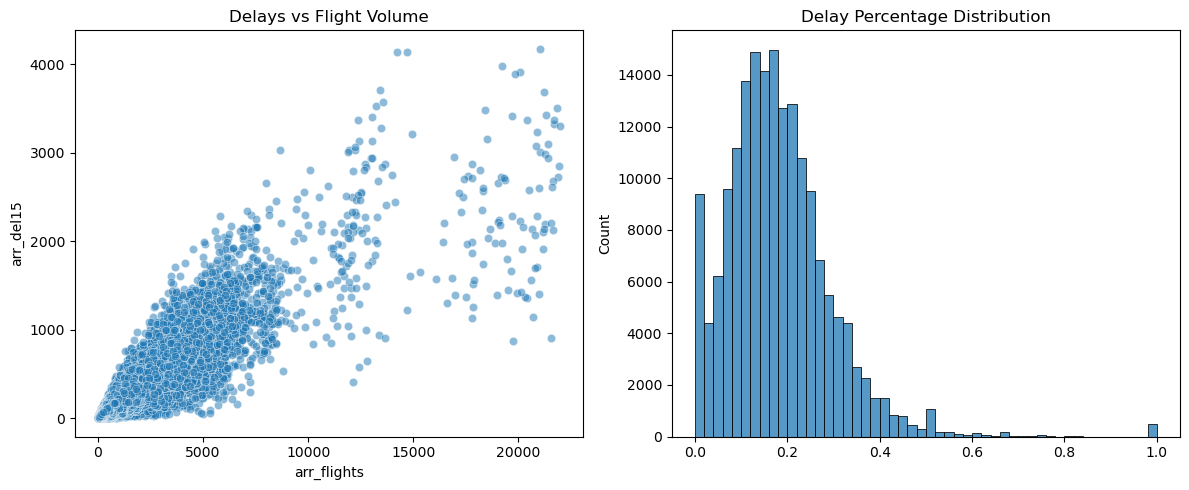

In [6]:
# Flight volume vs delays
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='arr_flights', y='arr_del15', data=df, alpha=0.5)
plt.title('Delays vs Flight Volume')

# Delay percentage distribution
plt.subplot(1,2,2)
delay_pct = df['arr_del15']/df['arr_flights']
sns.histplot(delay_pct, bins=50)
plt.title('Delay Percentage Distribution')
plt.tight_layout()
plt.show()

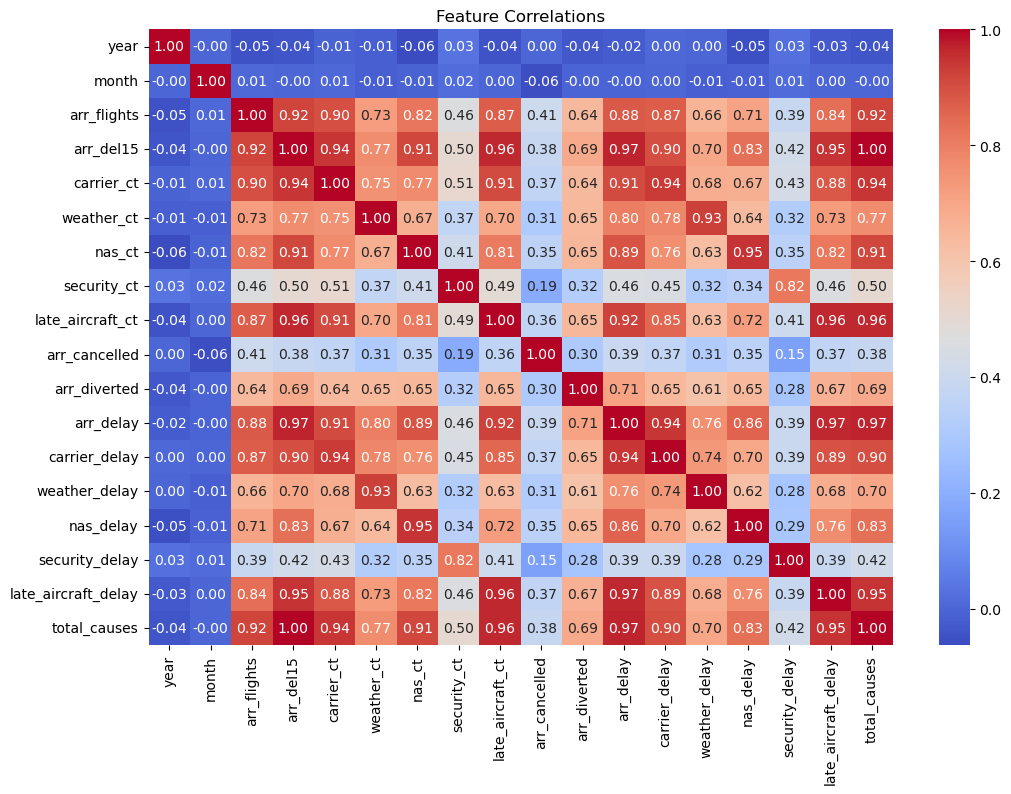

In [7]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

# 2. Data Cleaning and Preprocessing

In [8]:
# Ensure delay counts don't exceed total flights
invalid_delays = df[df['arr_del15'] > df['arr_flights']]
print(f"Rows with invalid delay counts: {len(invalid_delays)}")

# Cap delays at flight count
df['arr_del15'] = np.where(df['arr_del15'] > df['arr_flights'], 
                         df['arr_flights'], 
                         df['arr_del15'])

Rows with invalid delay counts: 0


In [9]:
# Fill missing counts with 0 (assuming no delays)
count_cols = ['arr_del15'] + [f'{cause}_ct' for cause in delay_causes]
df[count_cols] = df[count_cols].fillna(0)

# Fill missing delay minutes with 0
delay_min_cols = [f'{cause}_delay' for cause in delay_causes]
df[delay_min_cols] = df[delay_min_cols].fillna(0)

print("Missing values after treatment:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing values after treatment:
arr_flights      341
arr_cancelled    341
arr_diverted     341
arr_delay        341
dtype: int64


In [10]:
# Delay percentage
df['delay_pct'] = np.where(df['arr_flights'] > 0,
                         df['arr_del15'] / df['arr_flights'],
                         0)

# Delay cause ratios
for cause in delay_causes:
    df[f'{cause}_ratio'] = np.where(df['arr_del15'] > 0,
                                  df[f'{cause}_ct'] / df['arr_del15'],
                                  0)
    
print("\nNew features created: delay_pct, *_ratio")


New features created: delay_pct, *_ratio


In [11]:
# Convert month to cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

# Create seasons
season_map = {1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring',
              5:'Spring', 6:'Summer', 7:'Summer', 8:'Summer',
              9:'Fall', 10:'Fall', 11:'Fall', 12:'Winter'}
df['season'] = df['month'].map(season_map)

print("\nTemporal features created: month_sin, month_cos, season")


Temporal features created: month_sin, month_cos, season


In [12]:
# Cap extreme delay minutes at 95th percentile
for col in delay_min_cols:
    cap = df[col].quantile(0.95)
    df[col] = np.where(df[col] > cap, cap, df[col])

print("Delay minutes capped at 95th percentile")

Delay minutes capped at 95th percentile


In [13]:
# Convert to proper types
df['season'] = df['season'].astype('category')
df['carrier'] = df['carrier'].astype('category')
df['airport'] = df['airport'].astype('category')

print("\nCategory counts:")
print("Carriers:", df['carrier'].nunique())
print("Airports:", df['airport'].nunique())


Category counts:
Carriers: 29
Airports: 396



Final validation:
Delay pct range: (0.0, 1.0)
Cause ratios sum: count    179338.000000
mean          0.950030
std           0.217916
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.010000
dtype: float64


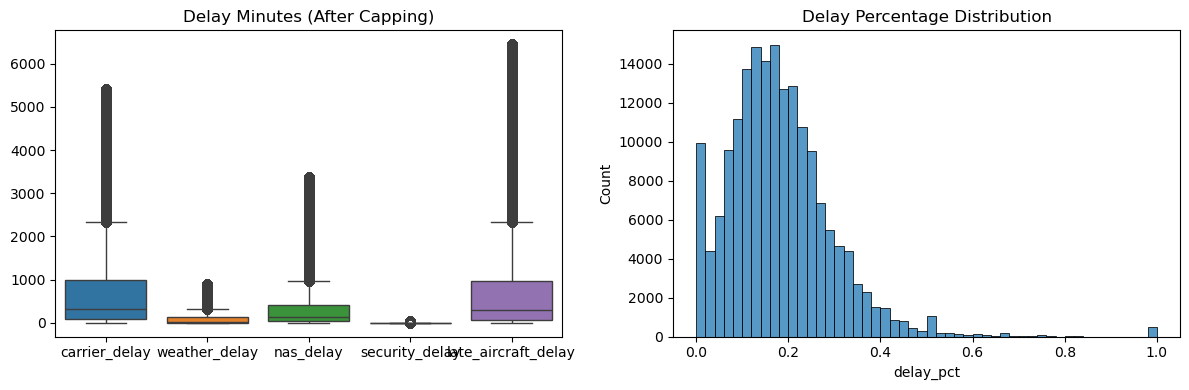

In [14]:
print("\nFinal validation:")
print("Delay pct range:", (df['delay_pct'].min(), df['delay_pct'].max()))
print("Cause ratios sum:", df[[f'{cause}_ratio' for cause in delay_causes]].sum(axis=1).describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(df[delay_min_cols])
plt.title('Delay Minutes (After Capping)')

plt.subplot(1,2,2)
sns.histplot(df['delay_pct'], bins=50)
plt.title('Delay Percentage Distribution')
plt.tight_layout()
plt.show()

# 3. Exploratory Data Analysis (EDA)

In [15]:
plt.style.use('ggplot')

## 3.1 Temporal Analysis

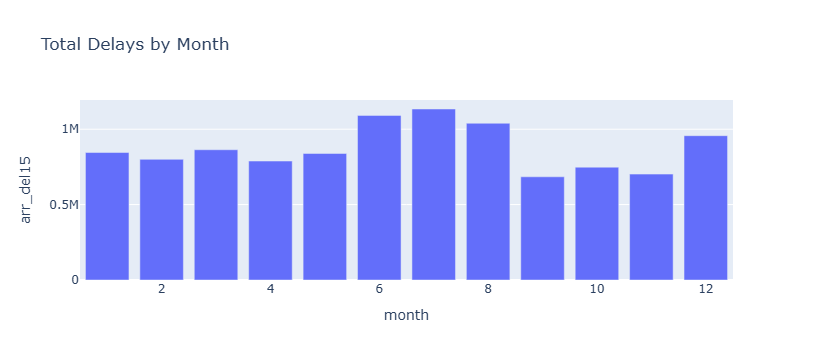

<Figure size 1200x600 with 0 Axes>

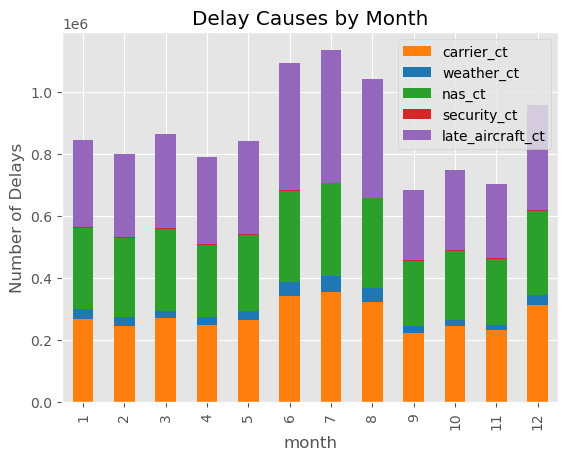

In [16]:
# Monthly delay patterns with causes
monthly_delays = df.groupby('month').agg({
    'arr_flights': 'sum',
    'arr_del15': 'sum',
    **{f'{cause}_ct': 'sum' for cause in delay_causes}
}).reset_index()

fig = px.bar(monthly_delays, 
             x='month', 
             y='arr_del15',
             color_discrete_sequence=['#636EFA'],
             title='Total Delays by Month')
fig.show()

# Stacked cause breakdown
plt.figure(figsize=(12,6))
monthly_delays.plot(x='month', 
                   y=[f'{cause}_ct' for cause in delay_causes],
                   kind='bar', 
                   stacked=True,
                   color=['#FF7F0E', '#1F77B4', '#2CA02C', '#D62728', '#9467BD'])
plt.title('Delay Causes by Month')
plt.ylabel('Number of Delays')
plt.show()

## 3.2 Airport Analysis

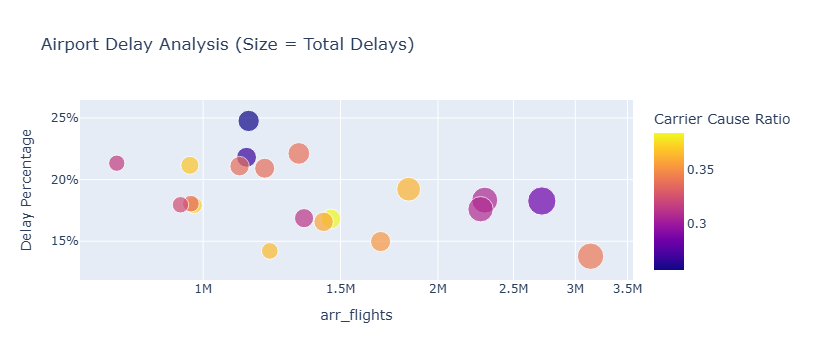

In [17]:
# Top 20 airports by delay percentage
airport_stats = df.groupby('airport_name').agg({
    'arr_flights': 'sum',
    'arr_del15': 'sum',
    **{f'{cause}_ratio': 'mean' for cause in delay_causes}
}).sort_values('arr_del15', ascending=False).head(20)

airport_stats['delay_pct'] = airport_stats['arr_del15'] / airport_stats['arr_flights']

# Interactive airport delay map
fig = px.scatter(airport_stats.reset_index(),
                x='arr_flights',
                y='delay_pct',
                size='arr_del15',
                color='carrier_ratio',
                hover_name='airport_name',
                log_x=True,
                title='Airport Delay Analysis (Size = Total Delays)',
                labels={'delay_pct': 'Delay Percentage', 
                       'carrier_ratio': 'Carrier Cause Ratio'})
fig.update_yaxes(tickformat=".0%")
fig.show()

## 3.3 Carrier Performance

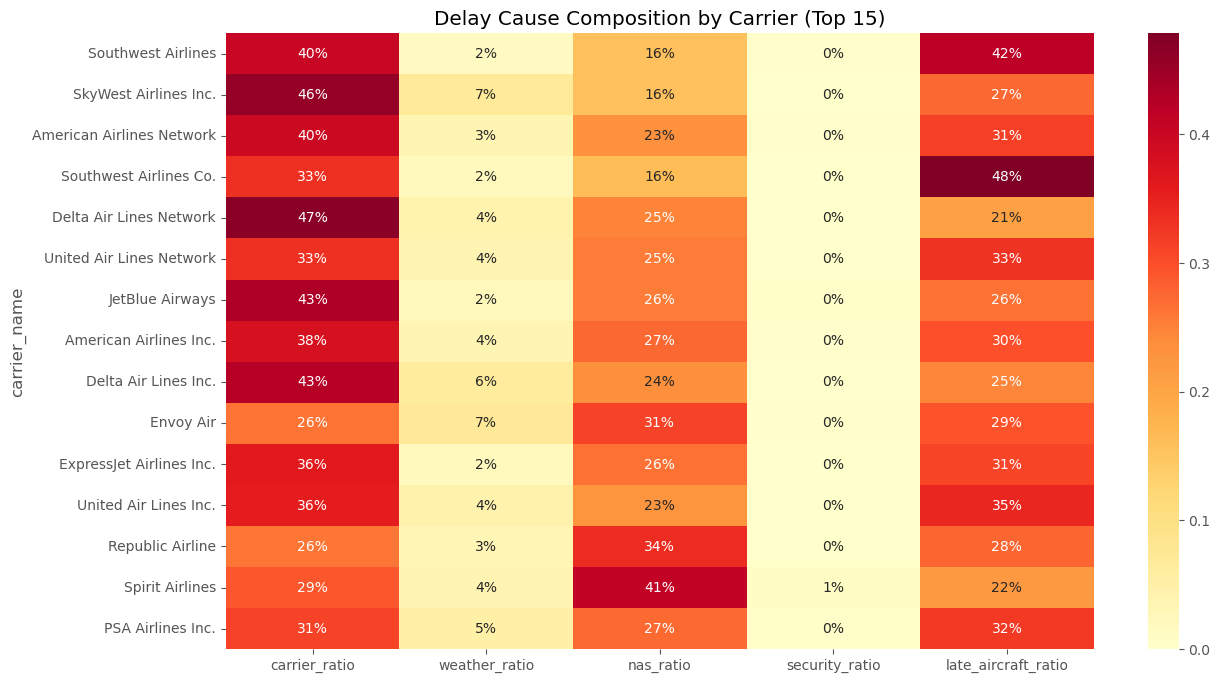

In [18]:
# Carrier delay profiles
carrier_delays = df.groupby('carrier_name').agg({
    'arr_flights': 'sum',
    'arr_del15': 'sum',
    **{f'{cause}_ratio': 'mean' for cause in delay_causes}
}).sort_values('arr_del15', ascending=False).head(15)

plt.figure(figsize=(14,8))
sns.heatmap(carrier_delays[[f'{cause}_ratio' for cause in delay_causes]],
           annot=True, fmt=".0%",
           cmap='YlOrRd')
plt.title('Delay Cause Composition by Carrier (Top 15)')
plt.show()

## 3.4 Delay Cause Correlation

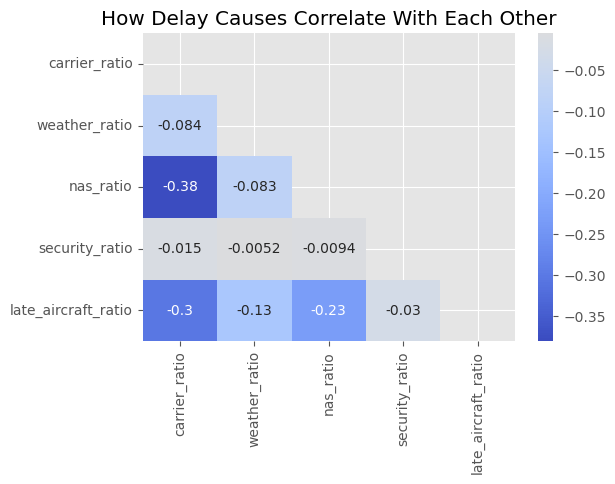

In [19]:
# Network graph of cause correlations
cause_corr = df[[f'{cause}_ratio' for cause in delay_causes]].corr()

plt.figure(figsize=(6,4))
sns.heatmap(cause_corr, 
           annot=True, 
           cmap='coolwarm', 
           center=0,
           mask=np.triu(np.ones_like(cause_corr)))
plt.title('How Delay Causes Correlate With Each Other')
plt.show()

## 3.5 3D Plot

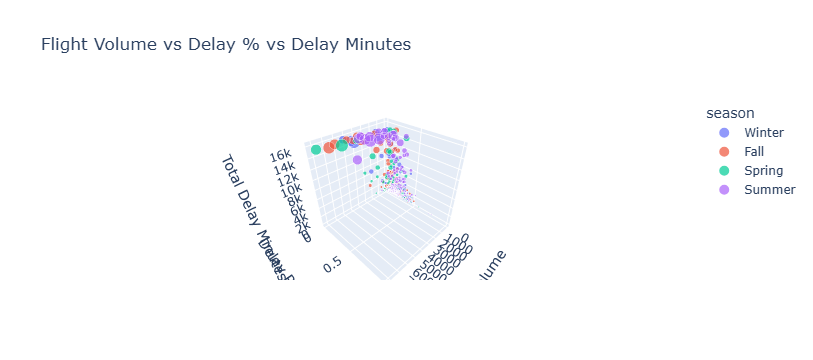

In [20]:
# Interactive 3D visualization
delay_min_cols = ['carrier_delay', 'weather_delay', 
                 'nas_delay', 'security_delay', 
                 'late_aircraft_delay']

df['total_delay_minutes'] = df[delay_min_cols].sum(axis=1)
fig = px.scatter_3d(df.sample(1000, random_state=1),
                   x='arr_flights',
                   y='delay_pct',
                   z='total_delay_minutes',
                   color='season',
                   size='arr_del15',
                   hover_name='carrier_name',
                   opacity=0.7,
                   title='Flight Volume vs Delay % vs Delay Minutes')
fig.update_layout(scene=dict(
                  xaxis_title='Flight Volume',
                  yaxis_title='Delay Percentage',
                  zaxis_title='Total Delay Minutes'))
fig.show()

## 3.6 ANOVA test

In [21]:
# ANOVA test for seasonal differences
seasons = [group['delay_pct'] for name, group in df.groupby('season')]
f_stat, p_value = f_oneway(*seasons)

print(f"Seasonal Delay Differences (ANOVA):")
print(f"F-statistic: {f_stat:.1f}, p-value: {p_value:.4f}")
print("Significant difference" if p_value < 0.05 else "No significant difference")

Seasonal Delay Differences (ANOVA):
F-statistic: 2801.2, p-value: 0.0000
Significant difference


C:\Users\heman\AppData\Local\Temp\ipykernel_5092\2455153819.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## 3.7 Airport Delay Heatmap

In [22]:
# Get top 15 airports by total delayed flights
top_15 = df.groupby(['airport', 'airport_name'])['arr_del15'].sum().nlargest(15).reset_index()
print("Top 15 Airports by Delayed Flights:")
display(top_15)

C:\Users\heman\AppData\Local\Temp\ipykernel_5092\1577306816.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Top 15 Airports by Delayed Flights:


airport                                       airport_name  arr_del15
0      ORD          Chicago, IL: Chicago O'Hare International   496364.0
1      ATL  Atlanta, GA: Hartsfield-Jackson Atlanta Intern...   432555.0
2      DFW  Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...   420954.0
3      DEN                   Denver, CO: Denver International   399147.0
4      LAX         Los Angeles, CA: Los Angeles International   352582.0
5      SFO     San Francisco, CA: San Francisco International   293470.0
6      EWR           Newark, NJ: Newark Liberty International   283188.0
7      CLT     Charlotte, NC: Charlotte Douglas International   252863.0
8      MCO                 Orlando, FL: Orlando International   250893.0
9      LGA                            New York, NY: LaGuardia   247907.0
10     PHX      Phoenix, AZ: Phoenix Sky Harbor International   244961.0
11     SEA          Seattle, WA: Seattle/Tacoma International   236511.0
12     BOS                    Boston, MA: Logan International   234820.0
13     IAH  Houston, TX: George Bush Intercontinental/Houston   227269.0
14     JFK        New York, NY: John F. Kennedy International   203441.0

In [23]:
# Check raw delay counts
delay_stats = df[df['airport'].isin(top_15['airport'])].groupby('airport').agg({
    'arr_del15': 'sum',
    **{f'{cause}_ct': 'sum' for cause in delay_causes}
})

print("Raw Delay Counts:")
display(delay_stats)

print("\nValidation:")
print("Total arr_del15:", delay_stats['arr_del15'].sum())
print("Delay cause totals:")
print(delay_stats[[f'{cause}_ct' for cause in delay_causes]].sum())

Raw Delay Counts:


C:\Users\heman\AppData\Local\Temp\ipykernel_5092\2208354587.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



arr_del15  carrier_ct  weather_ct  nas_ct  security_ct  \
airport                                                           
ABE            0.0         0.0         0.0     0.0          0.0   
ABI            0.0         0.0         0.0     0.0          0.0   
ABQ            0.0         0.0         0.0     0.0          0.0   
ABR            0.0         0.0         0.0     0.0          0.0   
ABY            0.0         0.0         0.0     0.0          0.0   
...            ...         ...         ...     ...          ...   
XWA            0.0         0.0         0.0     0.0          0.0   
YAK            0.0         0.0         0.0     0.0          0.0   
YKM            0.0         0.0         0.0     0.0          0.0   
YNG            0.0         0.0         0.0     0.0          0.0   
YUM            0.0         0.0         0.0     0.0          0.0   

         late_aircraft_ct  
airport                    
ABE                   0.0  
ABI                   0.0  
ABQ                   0.0  
ABR                   0.0  
ABY                   0.0  
...                   ...  
XWA                   0.0  
YAK                   0.0  
YKM                   0.0  
YNG                   0.0  
YUM                   0.0  

[396 rows x 6 columns]


Validation:
Total arr_del15: 4576925.0
Delay cause totals:
carrier_ct          1258494.18
weather_ct           151996.64
nas_ct              1637584.66
security_ct            9836.74
late_aircraft_ct    1519011.70
dtype: float64


In [24]:
# Calculate ratios with zero protection
delay_stats = (
    df[df['airport'].isin(top_15['airport'])]
    .groupby('airport')
    .agg({**{f'{cause}_ct': 'sum' for cause in delay_causes}, 'arr_del15': 'sum'})
)

# Filter and calculate ratios
heatmap_data = delay_stats[delay_stats['arr_del15'] > 0].copy()
for cause in delay_causes:
    heatmap_data[f'{cause}_ratio'] = heatmap_data[f'{cause}_ct'] / heatmap_data['arr_del15']

# Create labels safely
heatmap_data = heatmap_data.join(top_15.set_index('airport')['airport_name'])
heatmap_data['label'] = heatmap_data.index.astype(str) + " (" + heatmap_data['airport_name'].astype(str).str.split(',').str[0] + ")"
heatmap_data = heatmap_data.set_index('label')

# Clean up
heatmap_data = heatmap_data.replace([np.inf, -np.inf], 0).fillna(0)

print("\nFinal Ratios:")
display(heatmap_data[[f'{cause}_ratio' for cause in delay_causes]].head(16))


Final Ratios:


C:\Users\heman\AppData\Local\Temp\ipykernel_5092\852751691.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



carrier_ratio  weather_ratio  nas_ratio  \
label                                                              
ATL (Atlanta)                 0.302188       0.036192   0.293845   
BOS (Boston)                  0.288456       0.028513   0.339642   
CLT (Charlotte)               0.276824       0.039380   0.287160   
DEN (Denver)                  0.306304       0.032740   0.309365   
DFW (Dallas/Fort Worth)       0.269418       0.047553   0.311046   
EWR (Newark)                  0.192369       0.026101   0.537696   
IAH (Houston)                 0.279127       0.041551   0.364903   
JFK (New York)                0.279865       0.025138   0.381082   
LAX (Los Angeles)             0.303914       0.030076   0.356526   
LGA (New York)                0.228133       0.037141   0.473891   
MCO (Orlando)                 0.316898       0.024270   0.312424   
ORD (Chicago)                 0.248064       0.034004   0.376003   
PHX (Phoenix)                 0.324627       0.023677   0.255351   
SEA (Seattle)                 0.272771       0.032247   0.381807   
SFO (San Francisco)           0.235605       0.028787   0.442667   

                         security_ratio  late_aircraft_ratio  
label                                                         
ATL (Atlanta)                  0.001925             0.365851  
BOS (Boston)                   0.001860             0.341528  
CLT (Charlotte)                0.002813             0.393821  
DEN (Denver)                   0.001697             0.349894  
DFW (Dallas/Fort Worth)        0.002877             0.369106  
EWR (Newark)                   0.001186             0.242648  
IAH (Houston)                  0.001382             0.313036  
JFK (New York)                 0.002892             0.311022  
LAX (Los Angeles)              0.002930             0.306553  
LGA (New York)                 0.001678             0.259157  
MCO (Orlando)                  0.002850             0.343558  
ORD (Chicago)                  0.001437             0.340492  
PHX (Phoenix)                  0.003051             0.393294  
SEA (Seattle)                  0.003062             0.310109  
SFO (San Francisco)            0.001295             0.291645

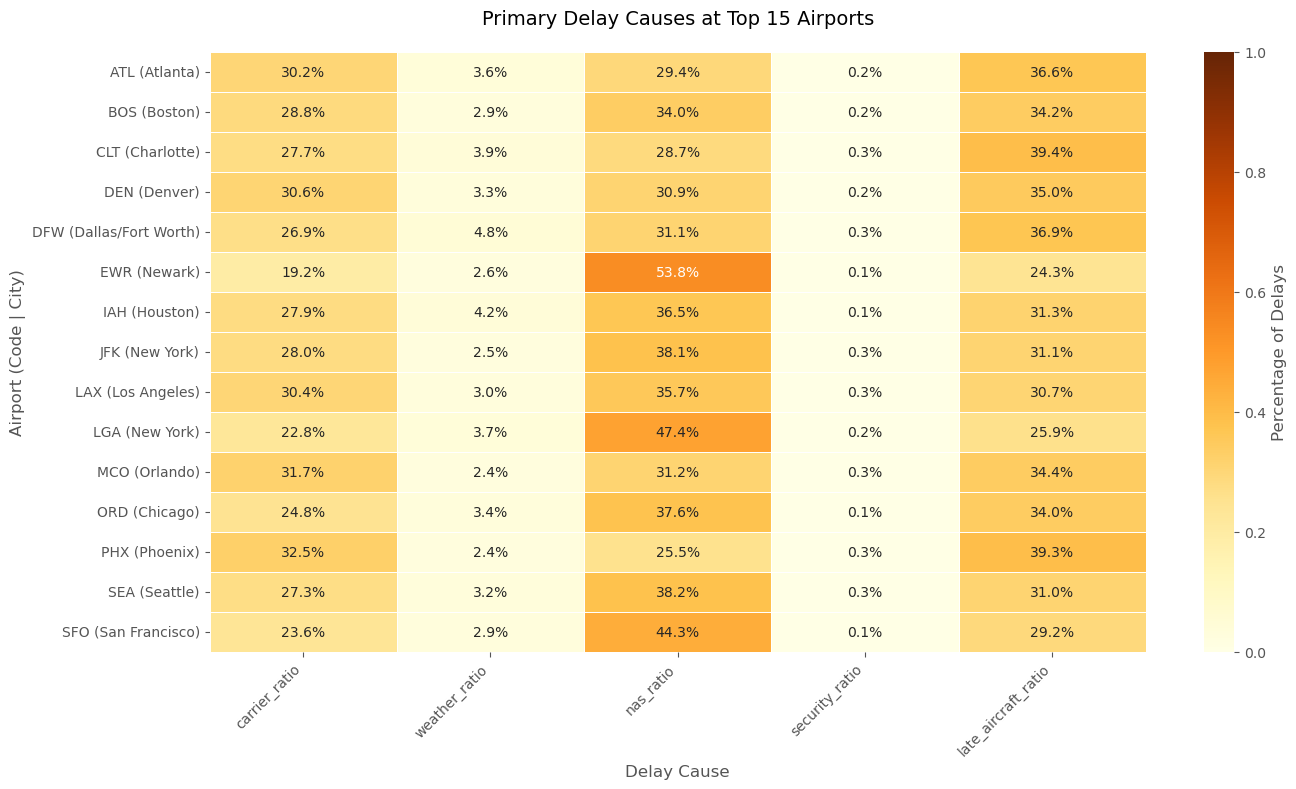

In [25]:
plt.figure(figsize=(14, 8))

# Extract just the ratio columns for plotting
plot_data = heatmap_data[[f'{cause}_ratio' for cause in delay_causes]]

sns.heatmap(
    plot_data,
    annot=True,
    fmt=".1%",  # Shows 10.5% instead of 0.105
    cmap='YlOrBr',
    linewidths=0.5,
    vmin=0,  # Ensures 0% is the minimum
    vmax=1,  # Ensures 100% is the maximum
    cbar_kws={'label': 'Percentage of Delays'}
)

plt.title('Primary Delay Causes at Top 15 Airports', pad=20, fontsize=14)
plt.xlabel('Delay Cause', fontsize=12)
plt.ylabel('Airport (Code | City)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 3.8 Delay Minute Distribution by Cause

C:\Users\heman\AppData\Local\Temp\ipykernel_5092\1141085889.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




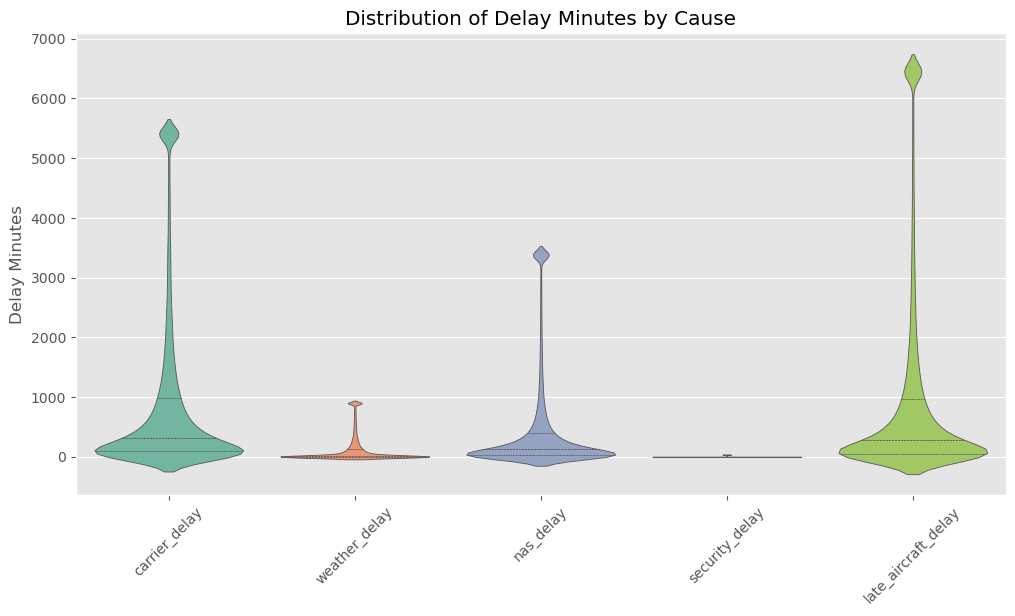

In [26]:
# Melt delay minutes
delay_melt = df.melt(
    value_vars=[f'{cause}_delay' for cause in delay_causes],
    var_name='cause', 
    value_name='minutes'
)

# Plot
plt.figure(figsize=(12,6))
sns.violinplot(data=delay_melt, 
              x='cause', y='minutes',
              palette='Set2',
              inner='quartile')
plt.title('Distribution of Delay Minutes by Cause')
plt.xticks(rotation=45)
plt.ylabel('Delay Minutes')
plt.xlabel('')
plt.show()

## 3.9 Flight Volume vs Delay Rate

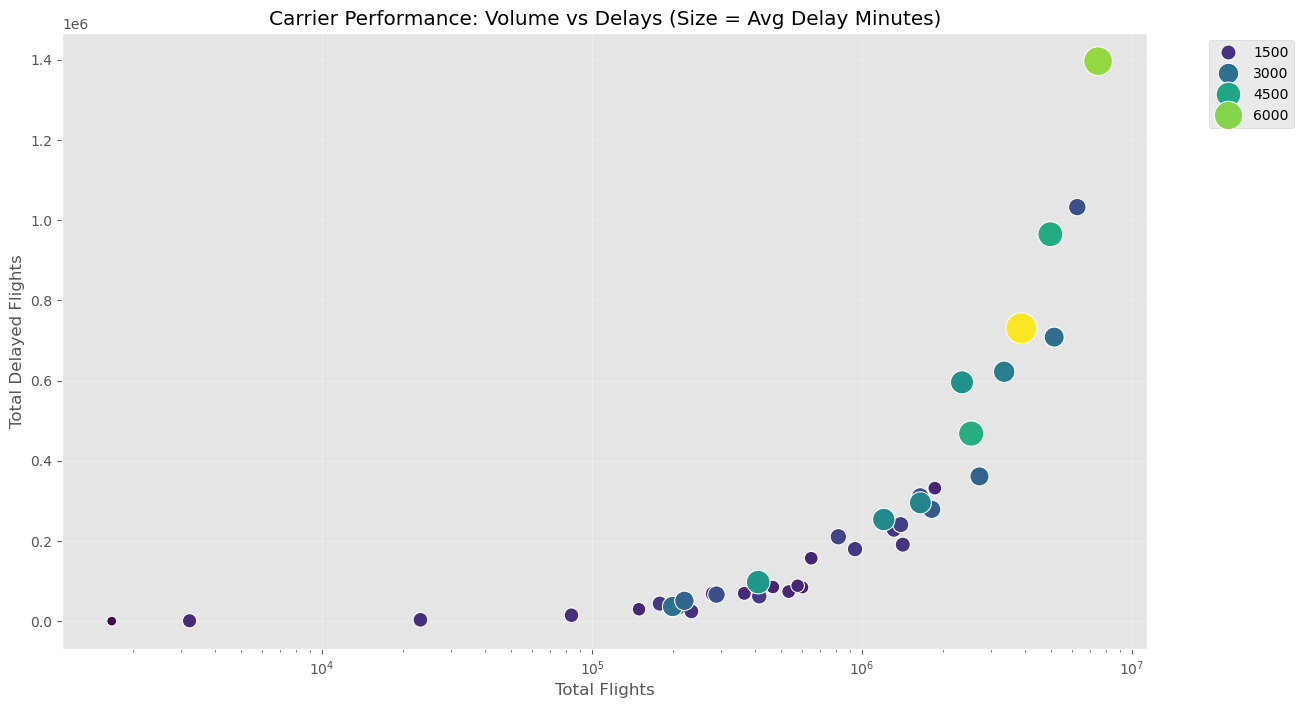

In [27]:
# Carrier-level aggregates
carrier_stats = df.groupby('carrier_name').agg({
    'arr_flights': 'sum',
    'arr_del15': 'sum',
    'total_delay_minutes': 'mean'
}).reset_index()

# Plot
plt.figure(figsize=(14,8))
sns.scatterplot(data=carrier_stats,
               x='arr_flights',
               y='arr_del15',
               size='total_delay_minutes',
               hue='total_delay_minutes',
               sizes=(50, 500),
               palette='viridis')
plt.title('Carrier Performance: Volume vs Delays (Size = Avg Delay Minutes)')
plt.xlabel('Total Flights')
plt.ylabel('Total Delayed Flights')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

## 3.10 Controllable vs Uncontrollable Delays

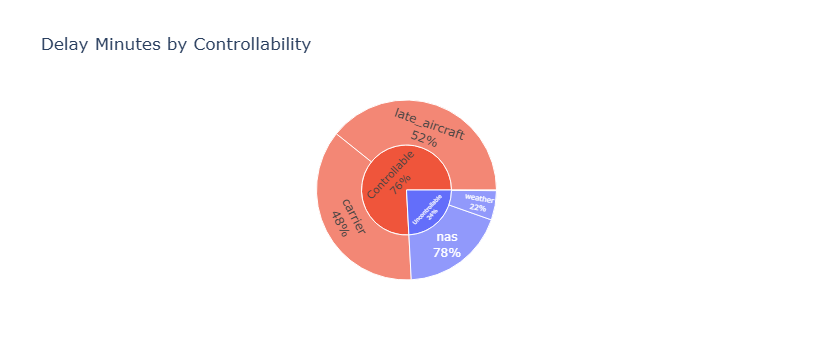

In [28]:
# Classify delay causes
controllable = ['carrier', 'late_aircraft']
uncontrollable = ['weather', 'security', 'nas']

# Prepare data
delay_types = pd.DataFrame({
    'type': ['Controllable']*len(controllable) + ['Uncontrollable']*len(uncontrollable),
    'cause': controllable + uncontrollable,
    'minutes': [df[f'{cause}_delay'].sum() for cause in controllable + uncontrollable]
})

# Plot (requires plotly)
fig = px.sunburst(delay_types,
                 path=['type', 'cause'],
                 values='minutes',
                 title='Delay Minutes by Controllability',
                 color='type',
                 color_discrete_map={
                     'Controllable': '#EF553B',
                     'Uncontrollable': '#636EFA'
                 })
fig.update_traces(textinfo="label+percent parent")
fig.show()

# 4. Feature Engineering and Data Split

## 4.1 Create Target Variables

In [29]:
# Create targets
df['is_delayed'] = (df['delay_pct'] > 0.1).astype(int)  # Binary classification
df['total_delay_minutes'] = df[[f'{cause}_delay' for cause in delay_causes]].sum(axis=1)  # Regression
print("Target variables created:")
print(f"- Classification: {df['is_delayed'].mean():.1%} delayed flights")
print(f"- Regression: Avg {df['total_delay_minutes'].mean():.1f} delay mins")

Target variables created:
- Classification: 76.2% delayed flights
- Regression: Avg 2457.6 delay mins


## 4.2 Feature Selection

In [30]:
features = {
    'temporal': ['month_sin', 'month_cos'],
    'categorical': ['season', 'carrier', 'airport'],
    'volume': ['arr_flights'],
    'delay_ratios': [f'{cause}_ratio' for cause in delay_causes]
}

X = df[sum(features.values(), [])]
y_class = df['is_delayed']
y_reg = df['total_delay_minutes']

print(f"Selected {X.shape[1]} features")
print("Numeric:", features['volume'] + features['delay_ratios'])
print("Categorical:", features['categorical'])

Selected 11 features
Numeric: ['arr_flights', 'carrier_ratio', 'weather_ratio', 'nas_ratio', 'security_ratio', 'late_aircraft_ratio']
Categorical: ['season', 'carrier', 'airport']


## 4.3 Train-Test Split

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, 
    test_size=0.2, 
    stratify=y_class, 
    random_state=42
)

# Align regression targets
_, _, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, 
    test_size=0.2, 
    stratify=y_class, 
    random_state=42
)

print(f"Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,} samples")

Train: 143,470 | Test: 35,868 samples


## 4.4 Preprocessing Pipeline

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = features['volume'] + features['delay_ratios']
categorical_features = features['categorical']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
], remainder='drop')

# Test fit
preprocessor.fit(X_train)
print("Preprocessor ready")

Preprocessor ready


## 4.5 Feature Names Extraction

In [33]:
# Get output feature names
numeric_names = numeric_features
categorical_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = list(numeric_names) + list(categorical_names)

print(f"Total features after preprocessing: {len(feature_names)}")
print("Example categorical names:", categorical_names[:5])

Total features after preprocessing: 435
Example categorical names: ['season_Fall' 'season_Spring' 'season_Summer' 'season_Winter'
 'carrier_9E']


## 4.6 Operational Adjustability Index (OAI)

In [34]:
# Calculate weighted delay score
delay_weights = {
    'carrier_ratio': 1.5,
    'late_aircraft_ratio': 1.3,
    'nas_ratio': 1.0,
    'weather_ratio': 0.7,
    'security_ratio': 0.5
}

for dataset in [X_train, X_test]:
    dataset['oai'] = sum(dataset[col]*weight for col, weight in delay_weights.items())

print(f"OAI range - Train: [{X_train['oai'].min():.1f}, {X_train['oai'].max():.1f}]")

OAI range - Train: [0.0, 1.5]


## 4.7 Verification

In [35]:
# Transform and verify
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

assert X_train_processed.shape[1] == len(feature_names), "Feature count mismatch"
assert not np.isnan(X_train_processed).any(), "NaN values detected"

print("Transformation successful")
print(f"Train shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")

Transformation successful
Train shape: (143470, 435)
Test shape: (35868, 435)


# 5. Model Building & Evaluation

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

## 5.1 Classification

In [37]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

In [38]:
results = {}
for name, clf in classifiers.items():
    # Create pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Train
    pipe.fit(X_train, y_train)
    
    # Evaluate
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    
    # Store results
    results[name] = {
        'accuracy': pipe.score(X_test, y_test),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'report': classification_report(y_test, y_pred)
    }
    
    print(f"{name} trained | AUC: {results[name]['roc_auc']:.3f}")

Logistic Regression trained | AUC: 0.791
Random Forest trained | AUC: 0.902


C:\Users\heman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[22:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBoost trained | AUC: 0.915


## 5.2 Regression

In [45]:
regressors = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor()
}

In [44]:
reg_results = {}
for name, reg in regressors.items():
    # Create pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', reg)
    ])
    
    # Train
    pipe.fit(X_train, y_train_reg)
    
    # Evaluate
    y_pred = pipe.predict(X_test)
    
    # Store results
    reg_results[name] = {
        'MAE': mean_absolute_error(y_test_reg, y_pred),
        'R2': r2_score(y_test_reg, y_pred)
    }
    
    print(f"{name} trained | MAE: {reg_results[name]['MAE']:.1f} mins")

MemoryError: Unable to allocate 470. MiB for an array with shape (143470, 429) and data type float64